In [307]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 17, 'figure.figsize': [15, 7]})
FIGSIZE = (15, 7)

### The idea
of this utility function is to utilize the knowledge of the last agent in order to optimize the district-wide losses. The previous problems we faced with building absolute values vs. district abs are lifted here, as the last building has prior knowledge about the rest of the district.

### Constants
Here we define all constants that we will re-derive throughout the notebook.

In [308]:
PRICING_FACTOR = 0.16004493105825985
PRICING_NO_BATTERY = 0.1889893403857968
EMISSION_NO_BATTERY = 0.10565039720688782
RAMPING_FACTOR = 0.7515799770633255  # = 0.3380755161315769 / 0.4498197483287821 = original sum * correction factor
RAMPING_NO_BATTERY = 0.3380755161315768
LOAD_FACTOR = 84.4161565292503
LOAD_FACTOR_LAST= 0.330985064760625
LOAD_NO_BATTERY = 1.9857512502718446e-05
UTILITY_OFFSET = 10
NET_CONS_MEDIAN = np.array([3.058308333396912, 2.7347333333333337, 2.309199999999999, 2.251299998537699, 4.265708333333334, 4.738175002503395, 3.7384416666666667, 2.4427625308740746, 1.8897083458503086, 2.150258333309492, 2.4845249979654946, 3.7908958333333325])
NET_CONS_MAX_ABV_MEDIAN = np.array([10.774841668269756, 13.983000000254311, 11.003333387447917, 9.412916668128972, 7.8483583333333335, 10.557608330829936, 7.527108333333334, 10.917187469125928, 7.106424987483024, 11.542174983747802, 12.195541668701171, 12.267887508265177])

### Functions from 'first agent'
Here we define the already-existing functions

In [309]:
def pricing_term_first(net_cons: float, prc: float) -> float:
    """
    net_cons: net consumption of one building in kWh
    prc: pricing['Electricity Pricing [$]']
    """
    positive_part = net_cons.clip(min=0) * prc
    negative_part = net_cons.clip(max=0)  * prc * PRICING_FACTOR
    return (positive_part + negative_part) / PRICING_NO_BATTERY


def carbon_intensity_term_first(net_cons: float, carbon_ints: float) -> float:
    """
    net_cons: net consumption of one building in kWh
    carbon_ints: carbon_intensity['kg_CO2/kWh']
    """
    return net_cons.clip(min=0) * carbon_ints / EMISSION_NO_BATTERY


def ramping_term_first(consumption_diff: float) -> float:
    """
    consumption_diff:net consumption diff kWh/h of one building
    """
    # return np.abs(consumption_diff) / RAMPING_FACTOR
    return consumption_diff.clip(min=0) / RAMPING_FACTOR / RAMPING_NO_BATTERY


def load_term_first(net_cons: float, month: int) -> float:
    """
    net_cons: net consumption of one building in kWh
    month: month of the year (0-11), given as hour of the year (0-8759)//730
    """
    net_cons_above_median = net_cons - NET_CONS_MEDIAN[month]
    exp_term = np.exp(net_cons_above_median.clip(min=0) / NET_CONS_MAX_ABV_MEDIAN[month]) - 1
    return exp_term / LOAD_FACTOR / LOAD_NO_BATTERY


def total_inst_u_first(net_cons: float, consumption_diff: float, prc: float, carbon_ints: float, month: int,
               weighting=(1., 1., .5, .5)) -> float:
    """
    net_cons: net consumption of one building in kWh
    consumption_diff: difference between the net consumption and the previous net consumption
    prc: pricing['Electricity Pricing [$]']
    carbon_ints: carbon_intensity['kg_CO2/kWh']
    month: month of the year (0-11), given as hour of the year (0-8759)//730
    """
    return (weighting[0] * pricing_term_first(net_cons, prc) + weighting[1] *
            carbon_intensity_term_first(net_cons, carbon_ints) + weighting[2] * ramping_term_first(consumption_diff) +
            weighting[3] * load_term_first(net_cons, month)) / sum(weighting)

## Price term
We start with the term as it's defined:

In [310]:
pricing = pd.read_csv(filepath_or_buffer="data/citylearn_challenge_2022_phase_1/pricing.csv")
net_consumption = pd.read_csv(filepath_or_buffer="data/buildings_net_electricity_consumption_without_storage.csv")
district_price = net_consumption.sum(axis=1).clip(lower=0) * pricing['Electricity Pricing [$]']

p0 = sum(district_price) / (365 * 24 * 5) / PRICING_NO_BATTERY
print(f"p0 = {p0}")

p0 = 1.0


Now we define an alternative loss that will be equivalent to the previous one.

We begin with complete knowledge, like every building is selected as the last one.

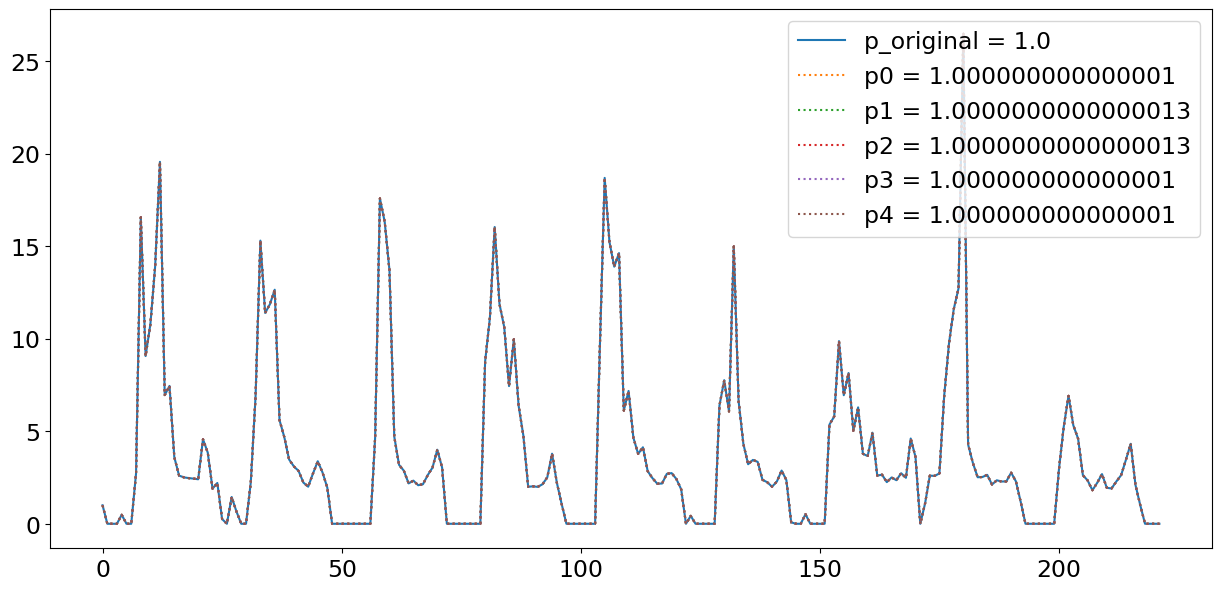

In [311]:
def pricing_term_last(net_cons: float, net_cons_rest: float, prc: float) -> float:
    """
    net_cons: net consumption of one building in kWh
    net_cons_rest: net consumption of all other buildings in kWh
    prc: pricing['Electricity Pricing [$]']
    building_number: number of the building, from 0 to out_of-1
    out_of: number of buildings
    """
    return (net_cons + net_cons_rest.sum(axis=1)).clip(min=0) * prc / PRICING_NO_BATTERY

pricing = pd.read_csv(filepath_or_buffer="data/citylearn_challenge_2022_phase_1/pricing.csv")
net_consumption = pd.read_csv(filepath_or_buffer="data/buildings_net_electricity_consumption_without_storage.csv")

plt.figure()
plt.plot(range(222), district_price[2000:2222] / PRICING_NO_BATTERY, label=f"p_original = {p0}")

for building in range(5):
    net_cons = net_consumption.iloc[:, building].to_numpy(copy=True)
    net_cons_rest = net_consumption.iloc[:, [i for i in range(5) if i != building]].to_numpy(copy=True)
    district_price_last = pricing_term_last(net_cons, net_cons_rest, pricing['Electricity Pricing [$]'])
    plt.plot(range(222), district_price_last[2000:2222], label=f"p{building} = {sum(district_price_last) / (365 * 24 * 5)}", linestyle=':')

plt.legend()
plt.show()

We can see that the loss is equivalent to the original one, as expected.

## Carbon emission term
We start with the term as it's defined:

In [312]:
carbon_intensity = pd.read_csv(filepath_or_buffer="data/citylearn_challenge_2022_phase_1/carbon_intensity.csv")
net_consumption_clipped = pd.read_csv(filepath_or_buffer="data/buildings_net_electricity_consumption_without_storage.csv").clip(lower=0)
district_carbon_intensity = net_consumption_clipped.sum(axis=1) * carbon_intensity['kg_CO2/kWh']
c0 = sum(district_carbon_intensity) / (365 * 24 * 5) / EMISSION_NO_BATTERY
print(f"c0 = {c0}")

c0 = 1.0


Now we define an alternative loss that will be equivalent to the previous one.

Here we don't have the total-district-subplus issue, as we take the positive part of each building's net consumption anyway.

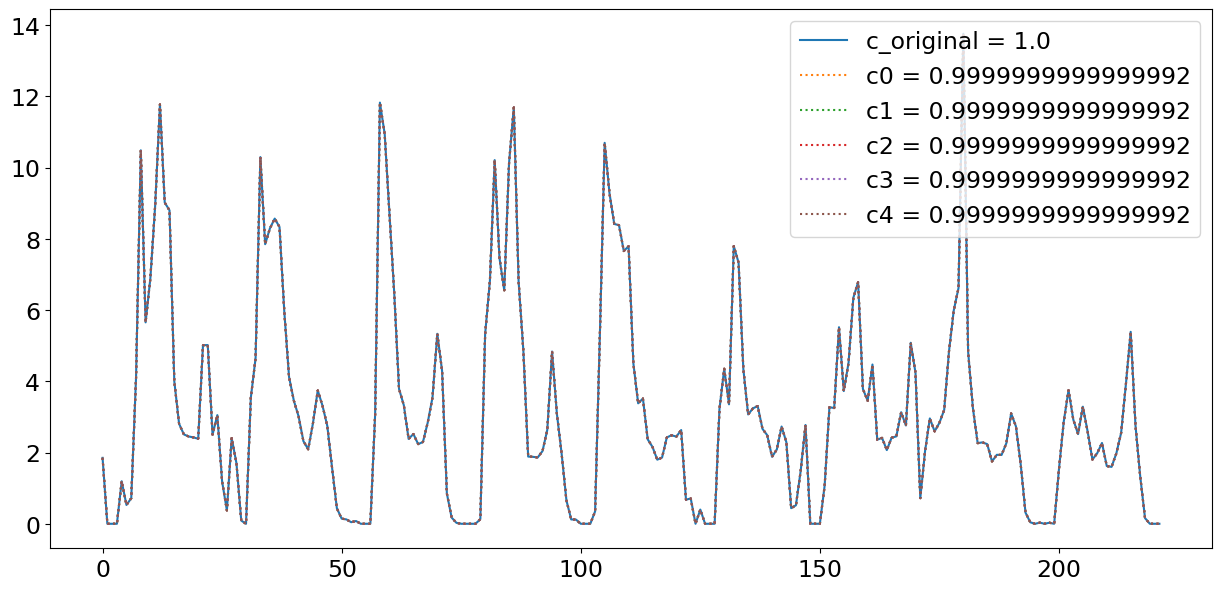

In [313]:
def carbon_intensity_term_last(net_cons: float, net_cons_rest: float, carbon_ints: float) -> float:
    """
    net_cons: net consumption of one building in kWh
    net_cons_rest: net consumption of all other buildings in kWh
    carbon_ints: carbon_intensity['kg_CO2/kWh']
    """
    return (net_cons.clip(min=0) + net_cons_rest.clip(min=0).sum(axis=1)) * carbon_ints / EMISSION_NO_BATTERY

carbon_intensity = pd.read_csv(filepath_or_buffer="data/citylearn_challenge_2022_phase_1/carbon_intensity.csv")
net_consumption = pd.read_csv(filepath_or_buffer="data/buildings_net_electricity_consumption_without_storage.csv")

plt.figure()
plt.plot(range(222), district_carbon_intensity[2000:2222] / EMISSION_NO_BATTERY, label=f"c_original = {c0}")

for building in range(5):
    net_cons = net_consumption.iloc[:, building].to_numpy(copy=True)
    net_cons_rest = net_consumption.iloc[:, [i for i in range(5) if i != building]].to_numpy(copy=True)
    district_carbon_intensity_last = carbon_intensity_term_last(net_cons, net_cons_rest, carbon_intensity['kg_CO2/kWh'].to_numpy(copy=True))
    plt.plot(range(222), district_carbon_intensity_last[2000:2222], label=f"c{building} = {sum(district_carbon_intensity_last) / (365 * 24 * 5)}", linestyle=':')

plt.legend()
plt.show()

## Ramping term

In [314]:
net_consumption = pd.read_csv(filepath_or_buffer="data/buildings_net_electricity_consumption_without_storage.csv")
net_consumption['sum'] = net_consumption.sum(axis=1)
net_consumption['abs diff'] = abs(net_consumption['sum'].diff().fillna(0))
net_consumption.head()

,Building_0,Building_1,Building_2,Building_3,Building_4,sum,abs diff
0,2.275800,2.188750,1.009623e-07,2.819150,0.771433,8.055133,0.000000
1,0.851167,1.370667,1.018524e-07,1.928167,0.515883,4.665883,3.389250
2,0.834600,1.101250,1.008352e-07,0.475817,0.503050,2.914717,1.751167
3,0.838167,0.543217,1.007080e-07,0.458233,0.535950,2.375567,0.539150
4,1.478433,0.542833,1.015981e-07,0.446017,0.512617,2.979900,0.604333


The sum abs of this diff should be taken and divided by 5 (buildings) and 365*24 (hours) to get the average power consumption per building per hour.

In [315]:
r0 = sum(net_consumption['abs diff']) / (365 * 24 * 5) / RAMPING_NO_BATTERY
print(f"r0 = {r0}")

r0 = 1.0


This is the value by which each delta net consumption should be normalized by to get the approximation for instantaneous $\frac{R_+}{R_-}$ term.

Now we will wrap this into a function that will take a dataframe with the net consumption and return the instantaneous $\frac{R_+}{R_-}$ term. Then we will show it is summed to 1.

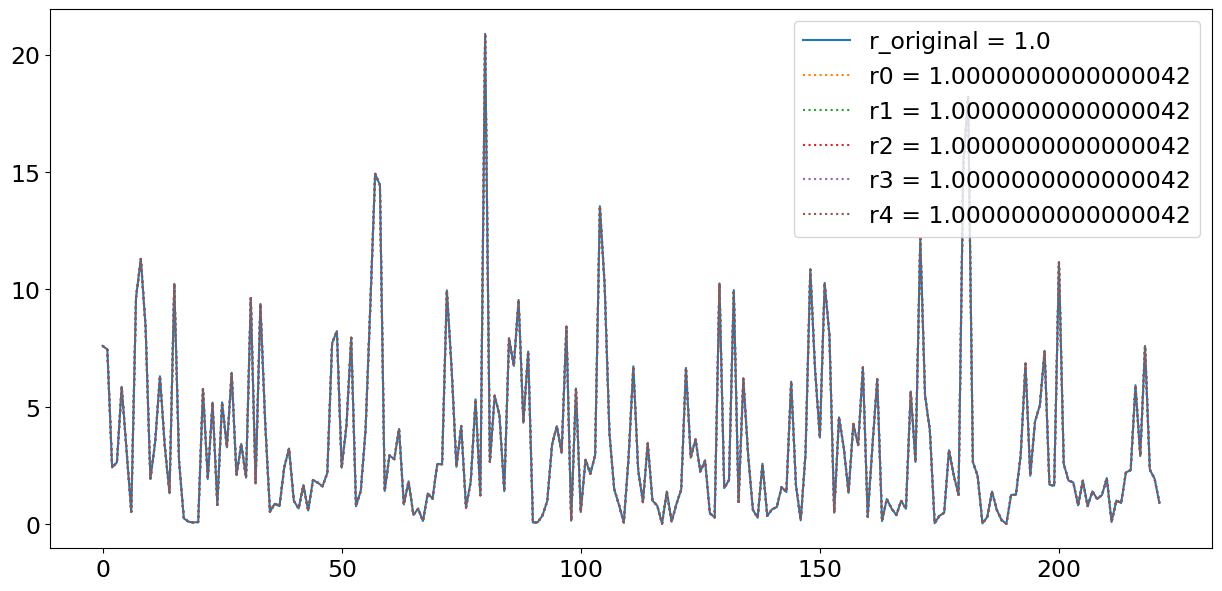

In [316]:
def ramping_term_last(consumption_diff: float, consumption_diff_rest: float) -> float:
    """
    consumption_diff:net consumption diff kWh/h of one building
    consumption_diff_rest: net consumption diff kWh/h of all other buildings
    """
    return abs(consumption_diff + consumption_diff_rest.sum(axis=1)) / RAMPING_NO_BATTERY

net_consumption = pd.read_csv(filepath_or_buffer="data/buildings_net_electricity_consumption_without_storage.csv")
net_consumption_diff = net_consumption.diff().fillna(0)

net_consumption['sum'] = net_consumption.sum(axis=1)
net_consumption['abs diff'] = abs(net_consumption['sum'].diff().fillna(0))

plt.figure()
plt.plot(range(222), net_consumption['abs diff'].iloc[2000:2222]  / RAMPING_NO_BATTERY, label=f"r_original = {r0}")

for building in range(5):
    net_cons = net_consumption_diff.iloc[:, building].to_numpy(copy=True)
    net_cons_rest = net_consumption_diff.iloc[:, [i for i in range(5) if i != building]].to_numpy(copy=True)
    district_ramping_term_last = ramping_term_last(net_cons, net_cons_rest)
    plt.plot(range(222), district_ramping_term_last[2000:2222], label=f"r{building} = {sum(district_ramping_term_last) / (365 * 24 * 5)}", linestyle=':')

plt.legend()
plt.show()

## Load term
We start with the term as it's defined:

In [317]:
window = 730
net_consumption = pd.read_csv(filepath_or_buffer="data/buildings_net_electricity_consumption_without_storage.csv")
net_consumption_sum = pd.DataFrame().assign(net_electricity_consumption=net_consumption.sum(axis=1))
net_consumption_sum['group'] = (net_consumption_sum.index/window).astype(int)
net_consumption_grouped = net_consumption_sum.groupby(['group'])[['net_electricity_consumption']].agg(['mean','max','median'])
net_consumption_grouped['load_factor'] = 1 - (net_consumption_grouped[('net_electricity_consumption','mean')]/net_consumption_grouped[('net_electricity_consumption','max')])
net_consumption_grouped['load_factor'] = net_consumption_grouped['load_factor'].rolling(window=net_consumption_grouped.shape[0],min_periods=1).mean()

net_consumption_grouped.head(6)

net_electricity_consumption                      load_factor
                             mean        max    median            
group                                                             
0                        2.863414  13.833150  3.058308    0.793003
1                        2.068934  16.717733  2.734733    0.834623
2                        1.262841  13.312533  2.309200    0.858129
3                        1.228048  11.664217  2.251300    0.867276
4                        3.347303  12.114067  4.265708    0.838557
5                        4.068800  15.295783  4.738175    0.821130

In [318]:
net_consumption = pd.read_csv(filepath_or_buffer="data/buildings_net_electricity_consumption_without_storage.csv")
net_consumption_np = net_consumption.sum(axis=1).to_numpy(copy=True)
max_vec = np.array(NET_CONS_MAX_ABV_MEDIAN + NET_CONS_MEDIAN).repeat(730)
true_L = (1 - (net_consumption_np / max_vec)) / (365 * 24)  # we absorb the (365 * 24) factor into L as only here they chose to take the mean rather than the sum
l0 = np.sum(true_L) / (365 * 24 * 5) / LOAD_NO_BATTERY
print(l0)

1.0


Now we define an alternative loss that will be equivalent to the previous one, but only for the sum.
It will use the exponent of cropped above median (w/o the division to 5 buildings) values to steer the consumption away from reaching a new monthly peak, where we introduce the penalty only for values above the median.

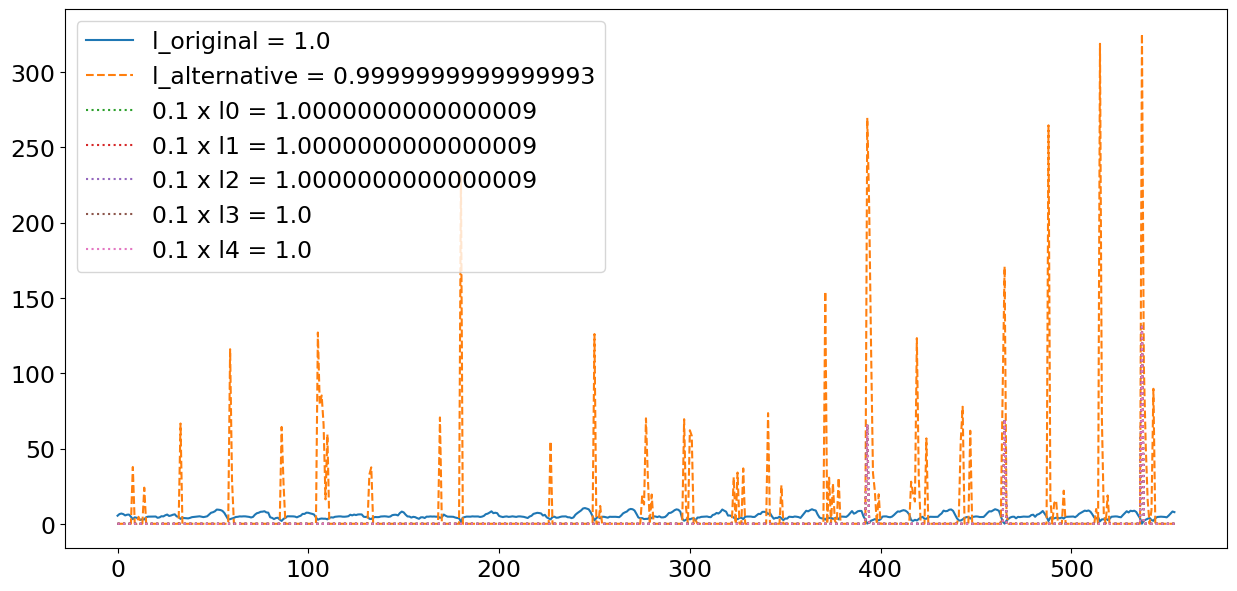

In [319]:
# def load_term_first(net_cons: float, month: int) -> float:
#     """
#     net_cons: net consumption of one building in kWh
#     month: month of the year (0-11), given as hour of the year (0-8759)//730
#     """
#     net_cons_above_median = net_cons - NET_CONS_MEDIAN[month]
#     exp_term = np.exp(net_cons_above_median.clip(min=0) / NET_CONS_MAX_ABV_MEDIAN[month]) - 1
#     return exp_term / LOAD_FACTOR / LOAD_NO_BATTERY


def load_term_last(net_cons:float, net_cons_rest: float, month: int, out_of) -> float:
    """
    net_cons: net consumption of one building in kWh
    net_cons_rest: net consumption of the rest of the buildings in kWh
    month: month of the year (0-11), given as hour of the year (0-8759)//730
    out_of: number of buildings in the district
    """
    net_cons_above_median = net_cons + net_cons_rest.sum(axis=1) - out_of * NET_CONS_MEDIAN[month]
    return (np.exp(net_cons_above_median.clip(min=0) / (out_of * NET_CONS_MAX_ABV_MEDIAN[month])) - 1) / LOAD_FACTOR_LAST / LOAD_NO_BATTERY

net_consumption = pd.read_csv(filepath_or_buffer="data/buildings_net_electricity_consumption_without_storage.csv")
load_inst_u = pd.DataFrame(load_term_first(net_consumption.to_numpy(copy=True), np.reshape(np.arange(8760) // 730, (-1, 1)))).sum(axis=1)

plt.figure()
plt.plot(range(555), true_L[2000:2555] / LOAD_NO_BATTERY, label=f"l_original = {l0}")
plt.plot(range(555), load_inst_u[2000:2555], label=f"l_alternative = {sum(load_inst_u.values) / (365 * 24 * 5)}", linestyle='--')

for building in range(5):
    net_cons = net_consumption.iloc[:, building].to_numpy(copy=True)
    net_cons_rest = net_consumption.iloc[:, [i for i in range(5) if i != building]].to_numpy(copy=True)
    district_load_term_last = load_term_last(net_cons, net_cons_rest, np.arange(8760) // 730, 5)
    plt.plot(range(555), district_load_term_last[2000:2555] / 10, label=f"0.1 x l{building} = {sum(district_load_term_last) / (365 * 24 * 5)}", linestyle=':')

plt.legend()
plt.show()


## Total utility
According to the original weighting, we define the instantaneous utility as:

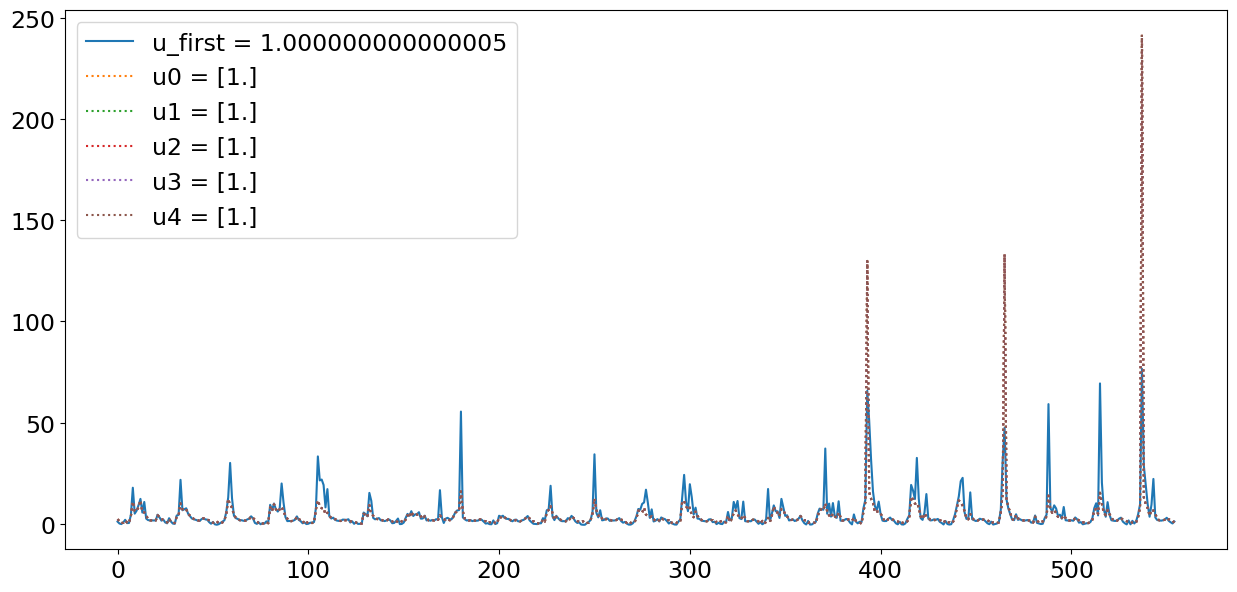

In [347]:
def total_inst_u_last(net_cons: float, net_cons_rest: float, consumption_diff: float, consumption_diff_rest: float,
                prc: float, carbon_ints: float, month: int, out_of: int, weighting=(1., 1., .5, .5)) -> float:
    """
    net_cons: net consumption of one building in kWh
    consumption_diff: difference between the net consumption and the previous net consumption
    prc: pricing['Electricity Pricing [$]']
    carbon_ints: carbon_intensity['kg_CO2/kWh']
    month: month of the year (0-11), given as hour of the year (0-8759)//730
    out_of: number of buildings in the district
    """
    return (weighting[0] * pricing_term_last(net_cons, net_cons_rest, prc) + weighting[1] * carbon_intensity_term_last(net_cons, net_cons_rest, carbon_ints) + weighting[2] * ramping_term_last(consumption_diff, consumption_diff_rest) + weighting[3] * load_term_last(net_cons, net_cons_rest, month, out_of)) / sum(weighting)

net_consumption = pd.read_csv(filepath_or_buffer="data/buildings_net_electricity_consumption_without_storage.csv")
net_consumption_diff = net_consumption.diff().fillna(0)
pricing = pd.read_csv(filepath_or_buffer="data/citylearn_challenge_2022_phase_1/pricing.csv")
carbon_intensity = pd.read_csv(filepath_or_buffer="data/citylearn_challenge_2022_phase_1/carbon_intensity.csv")

inst_u_first = pd.DataFrame(total_inst_u_first(net_consumption.to_numpy(copy=True),
                                               net_consumption_diff.to_numpy(copy=True),
                                               np.reshape(pricing['Electricity Pricing [$]'].to_numpy(copy=True), (-1, 1)),
                                               np.reshape(carbon_intensity['kg_CO2/kWh'].to_numpy(copy=True), (-1, 1)),
                                               np.reshape(np.arange(8760) // 730, (-1, 1)),
                                               weighting=(1., 1., .5, .5))).sum(axis=1)

plt.figure()
plt.plot(range(555), inst_u_first[2000:2555], label=f"u_first = {sum(inst_u_first.values) / (365 * 24 * 5)}")

for building in range(5):
    net_cons = net_consumption.iloc[:, building].to_numpy(copy=True)
    net_cons_diff = net_consumption_diff.iloc[:, building].to_numpy(copy=True)
    net_cons_rest = net_consumption.iloc[:, [i for i in range(5) if i != building]].to_numpy(copy=True)
    net_cons_diff_rest = net_consumption_diff.iloc[:, [i for i in range(5) if i != building]].to_numpy(copy=True)
    inst_u_last = pd.DataFrame(total_inst_u_last(net_cons,
                                                 net_cons_rest,
                                                 net_cons_diff,
                                                 net_cons_diff_rest,
                                                 pricing['Electricity Pricing [$]'].to_numpy(copy=True),
                                                 carbon_intensity['kg_CO2/kWh'].to_numpy(copy=True),
                                                 np.arange(8760) // 730,
                                                 5,
                                                 weighting=(1., 1., .5, .5)))

    plt.plot(range(555), inst_u_last[2000:2555], label=f"u{building} = {sum(inst_u_last.values) / (365 * 24 * 5)}", linestyle=':')

plt.legend()
plt.show()